In [169]:
### Imports
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib

In [170]:
### Load File
fullData = pd.read_csv('De-identified ARR Dataset - new.csv')

In [171]:
### Remove columns which either have all/mostly blank values
### or are the values we are attempting to predict
headers = list(fullData.columns.values)
badHeaders = [
    'id', 'BMI', 'Number of Future Relapses 1monthto3years', 
    'Number of Future Relapses 1yrto3yrs', 
    'NfLValue', 'HighNfL Binary'
]
for header in badHeaders:
    headers.remove(header)

trimmedData = fullData[headers]
print(trimmedData.columns.values)

['AgeatFV' 'SEX' 'RACE_DESC' 'ETHNICITY_DESC' 'FAMILY_MS' 'SMOKING_EVER'
 'DiseasedurationatFV' 'DISEASE_CATEGORY_DESC_FV' 'EDSS_FV'
 'PYRAMIDAL_FUNCTION' 'CEREBELLAR_FUNCTION' 'BRAINSTEM_FUNCTION'
 'SENSORY_FUNCTION' 'BOWEL_BLADDER_FUNCTION' 'VISUAL_FUNCTION'
 'MENTAL_FUNCTION' 'TotalnumberofrelapsesbeforeFV'
 'Numberofrelapsesinthe3yearsbeforeFV'
 'Numberofrelapsesinthe1yearbeforeFV' 'timeSinceLastAttack'
 'Future Relapse Binary' 'TreatmentBeforeFV' 'RelapseInYearBeforeFVBinary'
 'RelapseInThe3YearsBeforeFVBinary' 'Treatment with Injectable Med'
 'NewT2lesionYearBeforeFV' 'NewGadLesionYearBeforeFV']


In [172]:
### Find Blank Values
print(trimmedData.isna().sum()[trimmedData.isna().sum() > 0])

DiseasedurationatFV         1
EDSS_FV                   109
PYRAMIDAL_FUNCTION         98
CEREBELLAR_FUNCTION        99
BRAINSTEM_FUNCTION        100
SENSORY_FUNCTION           99
BOWEL_BLADDER_FUNCTION    102
VISUAL_FUNCTION            99
MENTAL_FUNCTION            99
dtype: int64


From this, we can see that feature *DiseasedurationatFV* has exactly 1 blank value. We simply drop this row.

In [173]:
trimmedData = trimmedData.dropna(subset=['DiseasedurationatFV'])
print(trimmedData.isna().sum()[trimmedData.isna().sum() > 0])
print(trimmedData.shape)

EDSS_FV                   109
PYRAMIDAL_FUNCTION         98
CEREBELLAR_FUNCTION        99
BRAINSTEM_FUNCTION        100
SENSORY_FUNCTION           99
BOWEL_BLADDER_FUNCTION    102
VISUAL_FUNCTION            99
MENTAL_FUNCTION            99
dtype: int64
(2191, 27)


In [174]:
# trimmedData2 = trimmedData.dropna(subset=['EDSS_FV'])
# #newtrimmedData = trimmedData.dropna(subset=['EDSS_FV', 'PYRAMIDAL_FUNCTION', 'CEREBELLAR_FUNCTION', 
# #                                         'BRAINSTEM_FUNCTION', 'SENSORY_FUNCTION', 'BOWEL_BLADDER_FUNCTION', 
# #                                         'VISUAL_FUNCTION', 'MENTAL_FUNCTION'], thresh=7)
# print(trimmedData2.isna().sum()[trimmedData2.isna().sum()>0])
# print(trimmedData2.shape)

In [198]:
print(trimmedData.iloc[::, 7:16].isna().value_counts())

DISEASE_CATEGORY_DESC_FV  EDSS_FV  PYRAMIDAL_FUNCTION  CEREBELLAR_FUNCTION  BRAINSTEM_FUNCTION  SENSORY_FUNCTION  BOWEL_BLADDER_FUNCTION  VISUAL_FUNCTION  MENTAL_FUNCTION
False                     False    False               False                False               False             False                   False            False              1993
                          True     False               False                False               False             False                   False            False                93
                          False    True                True                 True                True              True                    True             True                 80
                          True     True                True                 True                True              True                    True             True                 16
                          False    False               False                False               False            

In [176]:
# encoder = OneHotEncoder()

# trimmedData['RACE_DESC'] = pd.DataFrame(encoder.fit_transform(trimmedData[['RACE_DESC']]))
# print(trimmedData['RACE_DESC'].value_counts)

In [177]:
# imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)

# imputedData = imputer.fit_transform(trimmedData)

In [ ]:
blanksRemoved = trimmedData.dropna()
print(blanksRemoved.shape)
categoricalColumns = blanksRemoved.select_dtypes(include=['object']).columns.to_list()
remainingColumns = blanksRemoved.drop(columns=categoricalColumns)
oneHots = pd.get_dummies(blanksRemoved[categoricalColumns])
print(remainingColumns.shape)
print(oneHots.shape)
oneHotPlusNumerical = pd.concat([remainingColumns, oneHots],axis=1)
print(oneHotPlusNumerical.shape)
#print(oneHots)

(1993, 27)
(1993, 11)
(1993, 79)
0       1
1       1
2       0
3       1
4       1
       ..
2187    1
2188    0
2189    0
2190    1
2191    1
Name: Future Relapse Binary, Length: 1993, dtype: int64
(1993, 90)


In [179]:
print(oneHotPlusNumerical.index)
oneHotPlusNumerical.reset_index(drop = True, inplace = True)
print(oneHotPlusNumerical.index)

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191],
      dtype='int64', length=1993)
RangeIndex(start=0, stop=1993, step=1)


Difference
0    1115
1     878
Name: count, dtype: int64


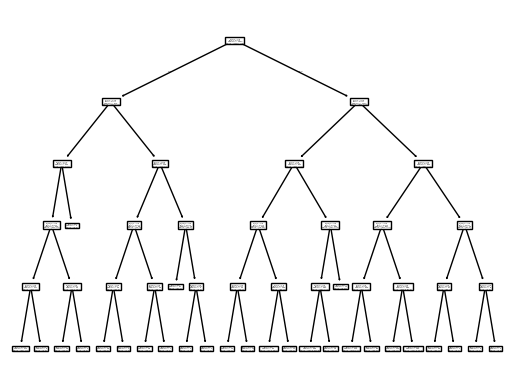

In [196]:
import warnings
warnings.filterwarnings('ignore')
treeClassifier = tree.DecisionTreeClassifier(max_depth=5)
indicator = oneHotPlusNumerical['Future Relapse Binary']
xValues = oneHotPlusNumerical.drop(['Future Relapse Binary'], axis=1)
treeModel = treeClassifier.fit(xValues, indicator)
tree.plot_tree(treeModel)

classificationResults = pd.DataFrame(columns=['Real Label', 'Predicted Label', 'Difference'])
classificationResultsArray = []
count = 0
for _, row in oneHotPlusNumerical.iterrows():
    classificationResultsArray.append(treeModel.predict([row[1:]])[0])
#     if row.iloc[8] != treeModel.predict([row[1:]])[0]:
#         print(f'Row {_}')
#         print(treeModel.predict([row[1:]])[0])
#         print(row.iloc[8])
#         count+= 1

# print(count)

classificationResults['Predicted Label'] = pd.Series(classificationResultsArray)
classificationResults['Real Label'] = oneHotPlusNumerical['Future Relapse Binary']
#print(classificationResults.shape)
classificationResults['Difference'] = abs(classificationResults['Real Label'] - classificationResults['Predicted Label'])
#print(classificationResults)
print(classificationResults['Difference'].value_counts())